In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

sys.path.insert(0, "..")

import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cogwheel import skyloc_angles, waveform
from cogwheel.gw_utils import DETECTORS, get_geocenter_delays
from cogwheel.utils import read_json
from dot_pe import config
from dot_pe.likelihood_calculating import LinearFree
from dot_pe.single_detector import SingleDetectorProcessor
import itertools

In [3]:
cache_dir = Path("posterior_cache")
coherent_posterior = read_json(cache_dir / "Posterior.json")
event_data = coherent_posterior.likelihood.event_data

bank_folder = Path("test_bank")
bank_config = read_json(bank_folder / "bank_config.json")
bank_config["fbin"] = np.array(bank_config["fbin"])
bank_config["m_arr"] = np.array(bank_config["m_arr"])
intrinsic_bank_df = pd.read_feather(bank_folder / "intrinsic_sample_bank.feather")

n_phi = 32
bank_file_path = bank_folder / "intrinsic_sample_bank.feather"
waveform_dir = bank_folder / "waveforms"

event_data_1d = copy.deepcopy(event_data)
det_name = event_data.detector_names[0]
det_indices = [event_data_1d.detector_names.index(det) for det in list(det_name)]

array_attributes = ["strain", "blued_strain", "wht_filter"]
for attr in array_attributes:
    setattr(event_data_1d, attr, getattr(event_data_1d, attr)[det_indices])

tuple_attributes = ["detector_names"]
for attr in tuple_attributes:
    temp = tuple(np.take(getattr(event_data_1d, attr), det_indices))
    setattr(event_data_1d, attr, temp)

par_dic_0 = coherent_posterior.likelihood.par_dic_0.copy()
wfg_1d = waveform.WaveformGenerator.from_event_data(
    event_data_1d, bank_config["approximant"]
)
likelihood_linfree = LinearFree(event_data_1d, wfg_1d, par_dic_0, bank_config["fbin"])

sdp = SingleDetectorProcessor(
    bank_file_path,
    waveform_dir,
    n_phi,
    bank_config["m_arr"],
    likelihood_linfree,
)

In [4]:
# intermezzo: check consistency of r->(d,psi) and (d,psi)->r transformations
consistency_dict = {
    "psi": np.random.uniform(0, np.pi),
    "d_luminosity": 1 / np.random.uniform(1e-4, 1e2),
    "det_name": "L",
}
consistency_dict["r"] = sdp.psi_and_d_luminosity_to_response(
    **consistency_dict
).squeeze()
consistency_dict["psi_reconstructed"], consistency_dict["d_reconstructed"] = (
    sdp.bestfit_response_to_psi_and_d_luminosity(
        consistency_dict["r"], consistency_dict["det_name"]
    )
)

# Compute psi abs error (modulo pi) and relative error
consistency_dict["psi_abs_error"] = np.abs(
    (
        (consistency_dict["psi_reconstructed"] - consistency_dict["psi"] + np.pi / 2)
        % np.pi
    )
    - np.pi / 2
)
consistency_dict["psi_rel_error"] = (
    consistency_dict["psi_abs_error"] / np.abs(consistency_dict["psi"])
    if np.abs(consistency_dict["psi"]) > 0
    else np.nan
)

# Compute d_luminosity abs and relative error
consistency_dict["d_abs_error"] = np.abs(
    consistency_dict["d_luminosity"] - consistency_dict["d_reconstructed"]
)
consistency_dict["d_rel_error"] = (
    consistency_dict["d_abs_error"] / np.abs(consistency_dict["d_luminosity"])
    if np.abs(consistency_dict["d_luminosity"]) > 0
    else np.nan
)
print("Intermezzo: check r->(d_luminosity,psi) consistency")
print(f"psi: {consistency_dict['psi']:.6f}")
print(f"psi_reconstructed: {consistency_dict['psi_reconstructed']:.6f}")
print(f"psi abs error (mod pi): {consistency_dict['psi_abs_error']:.10e}")
print(f"psi relative error (mod pi): {consistency_dict['psi_rel_error']:.6e}")

print(f"d_luminosity: {consistency_dict['d_luminosity']:.6e}")
print(f"d_reconstructed: {consistency_dict['d_reconstructed']:.6e}")
print(f"d_luminosity abs error: {consistency_dict['d_abs_error']:.6e}")
print(f"d_luminosity relative error: {consistency_dict['d_rel_error']:.6e}")

print("r:", consistency_dict["r"])


Intermezzo: check r->(d_luminosity,psi) consistency
psi: 2.217781
psi_reconstructed: 2.217781
psi abs error (mod pi): 0.0000000000e+00
psi relative error (mod pi): 0.000000e+00
d_luminosity: 1.549084e-02
d_reconstructed: 1.549088e-02
d_luminosity abs error: 3.950672e-08
d_luminosity relative error: 2.550328e-06
r: [21.62500658 60.82429055]


In [5]:
wfg = waveform.WaveformGenerator.from_event_data(event_data, bank_config["approximant"])

i = 5
intrinsic_params = intrinsic_bank_df.iloc[i].to_dict()
intrinsic_params["f_ref"] = bank_config["f_ref"]

waveform_par_dic_0 = intrinsic_params | config.DEFAULT_PARAMS_DICT
h_mpb_from_wfg = wfg.get_hplus_hcross(
    bank_config["fbin"], waveform_par_dic_0, by_m=True
)

amp, phase = sdp.intrinsic_sample_processor.load_amp_and_phase(
    bank_folder / "waveforms", np.array([i])
)
h_mpb_from_bank = (amp * np.exp(1j * phase))[0]

dt = sdp.intrinsic_sample_processor.cached_dt_linfree_relative[i]
print(f"dt: {dt}")

timeshift = np.exp(2j * np.pi * dt * bank_config["fbin"])
h_mpb_from_wfg *= timeshift[None, None, :]

print(f"h_mpb_from_wfg shape: {h_mpb_from_wfg.shape}")
print(f"h_mpb_from_bank shape: {h_mpb_from_bank.shape}")
print(f"h_mpb_from_wfg magnitude: {np.abs(h_mpb_from_wfg).max():.6e}")
print(f"h_mpb_from_bank magnitude: {np.abs(h_mpb_from_bank).max():.6e}")
print(f"Max abs diff: {np.max(np.abs(h_mpb_from_wfg - h_mpb_from_bank)):.6e}")
print(
    f"Relative diff: {np.max(np.abs(h_mpb_from_wfg - h_mpb_from_bank)) / np.abs(h_mpb_from_wfg).max():.6e}"
)

dt: 0.01518597154363809
h_mpb_from_wfg shape: (4, 2, 378)
h_mpb_from_bank shape: (4, 2, 378)
h_mpb_from_wfg magnitude: 2.622213e-20
h_mpb_from_bank magnitude: 2.622213e-20
Max abs diff: 3.080025e-34
Relative diff: 1.174590e-14


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


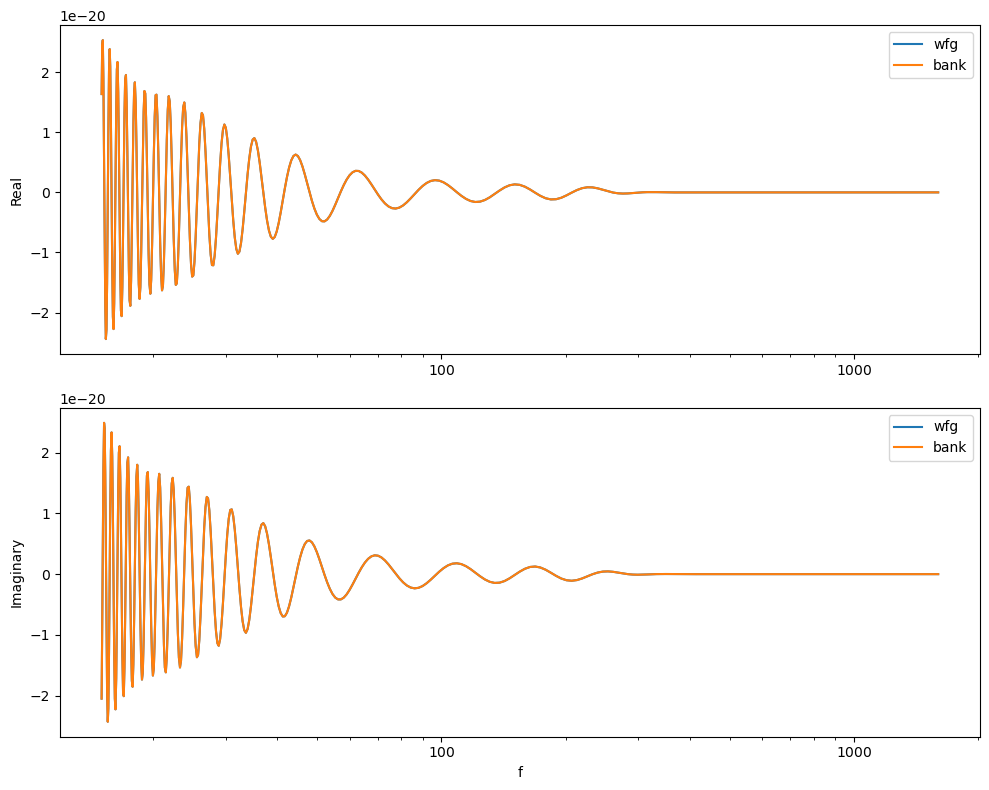

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.semilogx(bank_config["fbin"], h_mpb_from_wfg[0, 0, :].real, label="wfg")
ax1.semilogx(bank_config["fbin"], h_mpb_from_bank[0, 0, :].real, label="bank")
ax1.set_ylabel("Real")
ax1.legend()

ax2.semilogx(bank_config["fbin"], h_mpb_from_wfg[0, 0, :].imag, label="wfg")
ax2.semilogx(bank_config["fbin"], h_mpb_from_bank[0, 0, :].imag, label="bank")
ax2.set_xlabel("f")
ax2.set_ylabel("Imaginary")
ax2.legend()

plt.tight_layout()
plt.show()

In [7]:
print("\n" + "=" * 80)
print("PREPROCESSING SETUP FOR get_response_over_distance_and_lnlike")
print("=" * 80)

n_phi_incoherent = 64
n_t = 2048

batch_intrinsic_indices = np.array([i])
h_impb_batch = amp * np.exp(1j * phase)
sdp.h_impb = h_impb_batch

det_name_inner = sdp.likelihood.event_data.detector_names[0]
tgps_1d = sdp.likelihood.event_data.tgps
lat, lon = skyloc_angles.cart3d_to_latlon(
    skyloc_angles.normalize(DETECTORS[det_name_inner].location)
)

par_dic_transformed = sdp.transform_par_dic_by_sky_poisition(
    det_name_inner, par_dic_0, lon, lat, tgps_1d
)

delay_single = get_geocenter_delays(
    det_name_inner,
    par_dic_transformed["lat"],
    par_dic_transformed["lon"],
)[0]
tcoarse_1d = sdp.likelihood.event_data.tcoarse
dt_sample = sdp.likelihood.event_data.times[1]
# t_grid_single = (np.arange(n_t) - n_t // 2) * dt_sample
# t_grid_single += par_dic_transformed["t_geocenter"] + tcoarse_1d + delay_single
t_grid_single = (np.arange(n_t) - n_t // 2) * dt_sample + tcoarse_1d
timeshifts_dbt_single = np.exp(
    -2j * np.pi * t_grid_single[None, None, :] * sdp.likelihood.fbin[None, :, None]
)

print("Setup complete:")
print(f"  h_impb_batch shape: {h_impb_batch.shape}")
print(f"  dh_weights_dmpb shape: {sdp.dh_weights_dmpb.shape}")
print(f"  hh_weights_dmppb shape: {sdp.hh_weights_dmppb.shape}")
print(f"  timeshifts_dbt_single shape: {timeshifts_dbt_single.shape}")
print(f"  t_grid_single shape: {t_grid_single.shape}")
print(f"  lat, lon: {lat:.6f}, {lon:.6f}")
print(f"  delay_single: {delay_single:.6f}")
print(f"  par_dic_transformed[t_geocenter]: {par_dic_transformed['t_geocenter']:.6f}")


PREPROCESSING SETUP FOR get_response_over_distance_and_lnlike
Setup complete:
  h_impb_batch shape: (1, 4, 2, 378)
  dh_weights_dmpb shape: (1, 4, 2, 378)
  hh_weights_dmppb shape: (1, 10, 2, 2, 378)
  timeshifts_dbt_single shape: (1, 378, 2048)
  t_grid_single shape: (2048,)
  lat, lon: 0.530487, -1.584309
  delay_single: -0.021257
  par_dic_transformed[t_geocenter]: 0.025893


In [8]:
print(par_dic_transformed["t_geocenter"] + tcoarse_1d + delay_single)
print(t_grid_single.min(), t_grid_single.max())

60.00463663527404
59.68 60.3196875


In [9]:
print("\n" + "=" * 80)
print("LOOK INTO THE RESPONSE OPTIMIZATION")
print("=" * 80)

# Method 1: Using existing optimized code
print("\nMethod 1: Using get_response_over_distance_and_lnlike")
r_iotp_method1, lnlike_iot_method1 = sdp.get_response_over_distance_and_lnlike(
    sdp.dh_weights_dmpb,
    sdp.hh_weights_dmppb,
    sdp.h_impb,
    timeshifts_dbt_single,
    sdp.likelihood.asd_drift,
    sdp.likelihood_calculator.n_phi,
    sdp.likelihood_calculator.m_arr,
)
print(f"  r_iotp shape: {r_iotp_method1.shape}")
print(f"  lnlike_iot shape: {lnlike_iot_method1.shape}")
max_lnlike = lnlike_iot_method1.max()
max_indices1 = np.unravel_index(np.argmax(lnlike_iot_method1), lnlike_iot_method1.shape)
print(f"  Max lnlike: {max_lnlike:.6f}")
print(f"  Max lnlike indices (i, o, t): {[_.item() for _ in max_indices1]}")
print(f"  r_iotp at max lnlike: {r_iotp_method1[max_indices1]}")


# Method 2: Iterating over t and o explicitly
print("\nMethod 2: Explicit iteration over t and o")

i, m, p, b = h_impb_batch.shape
t = timeshifts_dbt_single.shape[-1]
n_phi = sdp.likelihood_calculator.n_phi

phi_grid_o = np.linspace(0, 2 * np.pi, n_phi, endpoint=False)
m_inds, mprime_inds = zip(*itertools.combinations_with_replacement(range(m), 2))
dh_phasor_mo = np.exp(-1j * np.outer(sdp.likelihood_calculator.m_arr, phi_grid_o))
hh_phasor_Mo = np.exp(
    1j
    * np.outer(
        sdp.likelihood_calculator.m_arr[m_inds,]
        - sdp.likelihood_calculator.m_arr[mprime_inds,],
        phi_grid_o,
    )
)

r_iotp_method2 = np.zeros((i, n_phi, t, p))
lnlike_iot_method2 = np.zeros((i, n_phi, t))

for i_idx in range(i):
    for t_idx in range(t):
        timeshift_t = timeshifts_dbt_single[0, :, t_idx]
        for o_idx, phi_o in enumerate(phi_grid_o):
            # Apply timeshift and phase shift
            h_shifted_conj = (
                h_impb_batch[i_idx].conj()
                * timeshift_t[None, :].conj()
                * np.exp(-1j * np.outer(sdp.likelihood_calculator.m_arr, phi_o))[
                    :, None
                ]
            )

            # Compute <d|h> per polarization
            dh_weights = sdp.dh_weights_dmpb[0] * sdp.likelihood.asd_drift[0] ** -2
            dh_p = np.sum(dh_weights * h_shifted_conj, axis=(0, 2)).real

            # Compute <h|h> per polarization pair
            hh_weights = sdp.hh_weights_dmppb[0] * sdp.likelihood.asd_drift[0] ** -2
            hh_pp = np.zeros((p, p))
            for M_idx, (m_idx, mprime_idx) in enumerate(zip(m_inds, mprime_inds)):
                for p_idx in range(p):
                    for pp_idx in range(p):
                        hh_pp[p_idx, pp_idx] += (
                            np.sum(
                                hh_weights[M_idx, p_idx, pp_idx]
                                * h_impb_batch[i_idx, m_idx, p_idx]
                                * h_impb_batch[i_idx, mprime_idx, pp_idx].conj()
                            )
                            * hh_phasor_Mo[M_idx, o_idx]
                        ).real

            # Invert matrix and solve for r
            hh_det = hh_pp[0, 0] * hh_pp[1, 1] - hh_pp[0, 1] * hh_pp[1, 0]
            if i_idx == 0 and t_idx == 0 and o_idx == 0:
                print(f"DEBUG: hh_pp = {hh_pp}")
                print(f"DEBUG: hh_det = {hh_det}")
                print(f"DEBUG: dh_p = {dh_p}")
            if hh_det > 0:
                hh_inv = (
                    np.array([[hh_pp[1, 1], -hh_pp[0, 1]], [-hh_pp[1, 0], hh_pp[0, 0]]])
                    / hh_det
                )
                r_p = hh_inv @ dh_p
            else:
                r_p = np.zeros(p)

            r_iotp_method2[i_idx, o_idx, t_idx] = r_p

            # Compute lnlike
            lnlike_iot_method2[i_idx, o_idx, t_idx] = np.sum(r_p * dh_p) - 0.5 * np.sum(
                r_p[:, None] * r_p[None, :] * hh_pp
            )

print(f"  r_iotp shape: {r_iotp_method2.shape}")
print(f"  lnlike_iot shape: {lnlike_iot_method2.shape}")
print(f"  Max lnlike: {lnlike_iot_method2.max():.6f}")
max_indices2 = np.unravel_index(np.argmax(lnlike_iot_method2), lnlike_iot_method2.shape)
print(f"  Max lnlike indices (i, o, t) (Method 2): {[_.item() for _ in max_indices2]}")
print(f"  r_iotp at max lnlike (Method 2): {r_iotp_method2[max_indices2]}")



LOOK INTO THE RESPONSE OPTIMIZATION

Method 1: Using get_response_over_distance_and_lnlike
  r_iotp shape: (1, 32, 2048, 2)
  lnlike_iot shape: (1, 32, 2048)
  Max lnlike: 14.330080
  Max lnlike indices (i, o, t): [0, 13, 1064]
  r_iotp at max lnlike: [-0.000376   -0.00010127]

Method 2: Explicit iteration over t and o
DEBUG: hh_pp = [[1.83303963e+08 1.39628053e+07]
 [1.57696043e+07 6.90690778e+07]]
DEBUG: hh_det = 1.244044776700204e+16
DEBUG: dh_p = [-16473.93767122 -10099.04419721]
  r_iotp shape: (1, 32, 2048, 2)
  lnlike_iot shape: (1, 32, 2048)
  Max lnlike: 14.330080
  Max lnlike indices (i, o, t) (Method 2): [0, 13, 1064]
  r_iotp at max lnlike (Method 2): [-0.000376   -0.00010127]


In [10]:
# Compare results
print("\nComparison:")
print(
    f"  Max lnlike difference: {np.abs(lnlike_iot_method1 - lnlike_iot_method2).max():.6e}"
)
print(f"  Max r difference: {np.abs(r_iotp_method1 - r_iotp_method2).max():.6e}")
print(
    f"  Relative r difference: {np.abs(r_iotp_method1 - r_iotp_method2).max() / np.abs(r_iotp_method1).max():.6e}"
)



Comparison:
  Max lnlike difference: 6.750156e-14
  Max r difference: 1.029992e-18
  Relative r difference: 1.738180e-15


In [11]:
print("\n" + "=" * 80)
print("COMMON LIKELIHOOD EVALUATION")
print("=" * 80)

# Get max indices for Method 1
i_idx1, o_idx1, t_idx1 = max_indices1

# Reconstruct parameter dictionary
intrinsic_params_from_bank = intrinsic_bank_df.iloc[
    batch_intrinsic_indices[i_idx1]
].to_dict()
intrinsic_params_from_bank["f_ref"] = bank_config["f_ref"]
intrinsic_params_from_bank["l1"] = 0
intrinsic_params_from_bank["l2"] = 0

psi_recon, d_luminosity_recon = sdp.bestfit_response_to_psi_and_d_luminosity(
    r_iotp_method1[max_indices1], sdp.likelihood.event_data.detector_names[0]
)

phi_ref_recon = o_idx1 / n_phi * 2 * np.pi

dt_linfree_for_this_sample = sdp.intrinsic_sample_processor.cached_dt_linfree_relative[
    batch_intrinsic_indices[i_idx1]
]
# t_geocenter_recon = (
#     par_dic_transformed["t_geocenter"]
#     + t_grid_single[t_idx1]
#     - tcoarse_1d
#     - delay_single
#     + dt_linfree_for_this_sample
# )

t_geocenter_recon = t_grid_single[t_idx1] - tcoarse_1d + dt_linfree_for_this_sample

reconstructed_par_dic = intrinsic_params_from_bank | {
    "ra": par_dic_transformed["ra"],
    "dec": par_dic_transformed["dec"],
    "t_geocenter": t_geocenter_recon,
    "phi_ref": phi_ref_recon,
    "psi": psi_recon,
    "d_luminosity": d_luminosity_recon,
}

print("Reconstructed parameters:")
print(f"  psi: {psi_recon:.6f}")
print(f"  d_luminosity: {d_luminosity_recon:.6f}")
print(f"  phi_ref: {phi_ref_recon:.6f}")
print(f"  t_geocenter: {t_geocenter_recon:.6f}")

# Compute likelihood using coherent_posterior
lnlike_from_coherent = coherent_posterior.likelihood.lnlike(reconstructed_par_dic)

print("\nLikelihood comparison:")
print(f"  From barebones calculation: {max_lnlike:.6f}")
print(f"  From coherent_posterior.lnlike: {lnlike_from_coherent:.6f}")
print(f"  Difference: {max_lnlike - lnlike_from_coherent:.6f}")

if abs(max_lnlike - lnlike_from_coherent) < 0.01:
    print("\n[PASS] Likelihoods match! Traceability verified.")
else:
    print("\n[FAIL] Likelihoods don't match. Need to investigate further.")


COMMON LIKELIHOOD EVALUATION
Reconstructed parameters:
  psi: 1.130038
  d_luminosity: 2568.062380
  phi_ref: 2.552544
  t_geocenter: 0.027686

Likelihood comparison:
  From barebones calculation: 14.330080
  From coherent_posterior.lnlike: -22.248807
  Difference: 36.578886

[FAIL] Likelihoods don't match. Need to investigate further.


In [12]:
batch_intrinsic_indices

array([5])

In [13]:
i

1

In [14]:
i_idx1

np.int64(0)

In [15]:
batch_intrinsic_indices[i_idx1]

np.int64(5)

In [16]:
t_grid_single[t_idx1] - tcoarse_1d

np.float64(0.012500000000002842)

14.136326228557298
0.018637029799706883


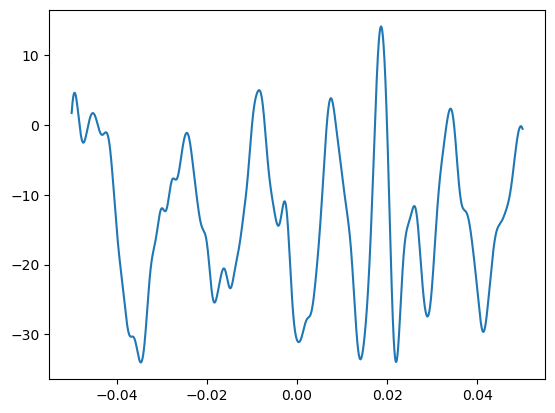

In [17]:
## 1-d time scan
from cogwheel.likelihood import CBCLikelihood

cbc_likelihood = CBCLikelihood(coherent_posterior.likelihood.event_data, wfg)

t_scan = np.linspace(-0.05, +0.05, 2048)
lnlike_t_scan = np.array(
    [
        cbc_likelihood.lnlike_fft(reconstructed_par_dic | {"t_geocenter": t})
        for t in t_scan
    ]
)


plt.plot(t_scan, lnlike_t_scan)

print(lnlike_t_scan.max())
print(t_scan[lnlike_t_scan.argmax()])

14.353646499337904
0.018620268620268624


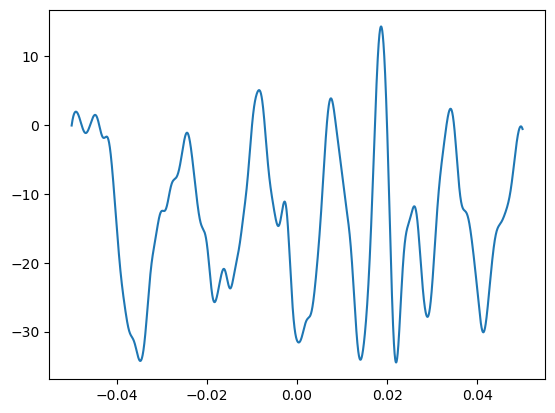

In [18]:
## 1-d time scan
from cogwheel.likelihood import CBCLikelihood


t_scan = np.linspace(-0.05, +0.05, 4096)
lnlike_t_scan = np.array(
    [
        coherent_posterior.likelihood.lnlike(reconstructed_par_dic | {"t_geocenter": t})
        for t in t_scan
    ]
)


plt.plot(t_scan, lnlike_t_scan)

print(lnlike_t_scan.max())
print(t_scan[lnlike_t_scan.argmax()])

In [19]:
print(f"{t_scan[lnlike_t_scan.argmax()]=}")
print(f"{sdp.intrinsic_sample_processor.cached_dt_linfree_relative[0]=}")
print(f"{delay_single=}")
print(f"{par_dic_transformed['t_geocenter']=}")

t_scan[lnlike_t_scan.argmax()]=np.float64(0.018620268620268624)


KeyError: 0

In [ ]:
t_grid_single[t_idx1]

In [ ]:
(np.arange(n_t) - n_t // 2) * dt_sample

In [ ]:
print(coherent_posterior.likelihood.lnlike(par_dic_0))
print(coherent_posterior.likelihood.lnlike(par_dic_transformed))

In [ ]:
-delay_single - par_dic_transformed["t_geocenter"] - sdp.intrinsic_sample_processor.cached_dt_linfree_relative[0]

In [ ]:
sdp.intrinsic_sample_processor.cached_dt_linfree_relative[0]

In [ ]:
cbc_likelihood = CBCLikelihood(coherent_posterior.likelihood.event_data, wfg)

print(cbc_likelihood.lnlike_fft(par_dic_transformed))
print(cbc_likelihood.lnlike_fft(par_dic_0))

print(
    cbc_likelihood.lnlike_fft(
        reconstructed_par_dic | {"t_geonceter": t_scan[lnlike_t_scan.argmax()]}
    )
)